Loading data from your uploaded files...
Files read successfully!
Cleaning and merging data...
Data cleaned. Total rows ready for analysis: 6275
   iso_code  year  co2_per_capita Country Code Country Name          gdp
40      AFG  2000           0.052          AFG  Afghanistan  1617.826475
41      AFG  2001           0.053          AFG  Afghanistan  1454.110782
42      AFG  2002           0.063          AFG  Afghanistan  1774.308743
43      AFG  2003           0.069          AFG  Afghanistan  1815.928200
44      AFG  2004           0.053          AFG  Afghanistan  1776.918207

--- Summary Statistics (Mean, Std, Min, Max) ---
       co2_per_capita            gdp
count     6275.000000    6275.000000
mean         5.014295   21036.456463
std          8.172982   23618.461187
min          0.022000     510.822823
25%          0.657000    4222.689655
50%          2.531000   12078.918532
75%          6.854500   30356.817167
max        364.688000  174339.002047


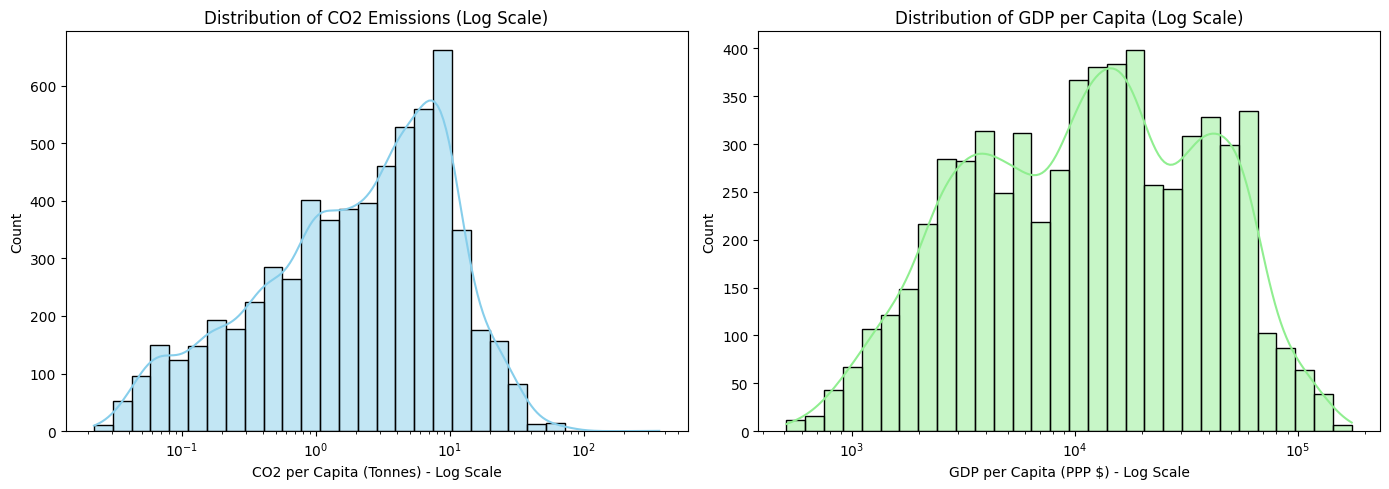

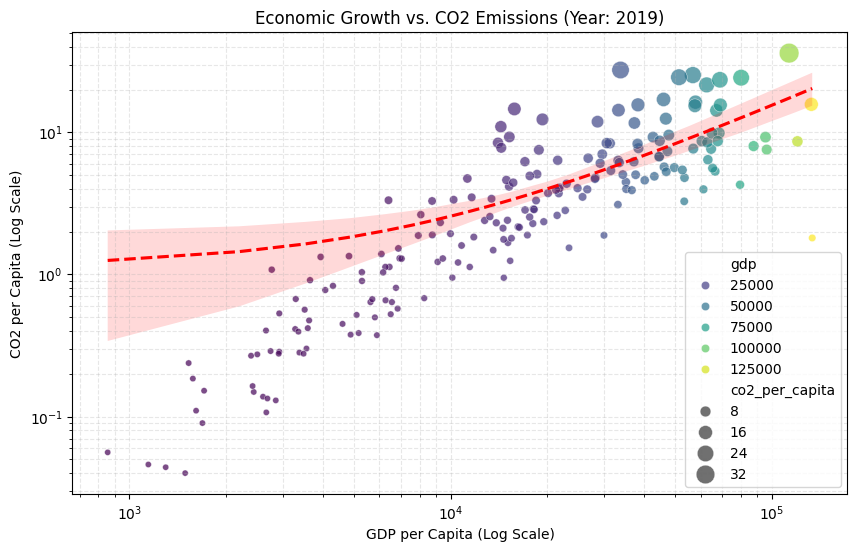


--- Hypothesis Testing ---
Pearson Correlation Coefficient (on log-transformed data): 0.9014
P-value: 0.0
RESULT: Null Hypothesis is REJECTED.
Interpretation: There is a statistically significant correlation between GDP and CO2 emissions.
Direction: The relationship is POSITIVE (As GDP increases, CO2 tends to increase).


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# 1. DATA COLLECTION (Loading the Data)
print("Loading data from your uploaded files...")

# A. Read the CO2 file
co2_filename = 'owid-co2-data (1).csv'
gdp_filename = 'API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2_130128.csv'

try:
    df_co2 = pd.read_csv(co2_filename)
    # The GDP file usually has empty rows at the top, so we skip the first 4 rows.
    df_gdp_raw = pd.read_csv(gdp_filename, skiprows=4)
    print("Files read successfully!")
except FileNotFoundError:
    print("ERROR: Files not found! Please make sure both CSV files are uploaded to Colab.")
    raise

# 2. DATA CLEANING AND PREPARATION
print("Cleaning and merging data...")

# Organize GDP Data:
# We only need the years and country codes. We filter numerical columns.
year_columns = [col for col in df_gdp_raw.columns if col.isdigit()]
cols_to_keep = ['Country Code', 'Country Name'] + year_columns
df_gdp = df_gdp_raw[cols_to_keep]

# Transform GDP data from Wide format to Long format (Rows instead of Columns)
df_gdp_melted = df_gdp.melt(id_vars=['Country Code', 'Country Name'], var_name='year', value_name='gdp')
df_gdp_melted['year'] = pd.to_numeric(df_gdp_melted['year'])

# Prepare CO2 Data:
# We select only the necessary columns.
df_co2_clean = df_co2[['iso_code', 'year', 'co2_per_capita']].copy()

# MERGE DATA:
# We combine the GDP and CO2 tables using 'Country Code' and 'Year'.
df = pd.merge(df_co2_clean, df_gdp_melted, left_on=['iso_code', 'year'], right_on=['Country Code', 'year'])

# Filter the data:
# 1. We look at years between 1990 and 2022.
# 2. We remove missing values (NaN) and zero values to avoid errors with Logarithms.
df = df[(df['year'] >= 1990) & (df['year'] <= 2022)]
df = df.dropna(subset=['co2_per_capita', 'gdp'])
df = df[(df['co2_per_capita'] > 0) & (df['gdp'] > 0)]

print(f"Data cleaned. Total rows ready for analysis: {len(df)}")
print(df.head())

# 3. EXPLORATORY DATA ANALYSIS (EDA)

# A. Summary Statistics
print("\n--- Summary Statistics (Mean, Std, Min, Max) ---")
print(df[['co2_per_capita', 'gdp']].describe())

# B. Histogram (Visualizing Distributions)
# We use a Log Scale because the data is skewed (many poor countries, few rich ones).
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['co2_per_capita'], bins=30, kde=True, ax=ax[0], color='skyblue', log_scale=True)
ax[0].set_title('Distribution of CO2 Emissions (Log Scale)')
ax[0].set_xlabel('CO2 per Capita (Tonnes) - Log Scale')

sns.histplot(df['gdp'], bins=30, kde=True, ax=ax[1], color='lightgreen', log_scale=True)
ax[1].set_title('Distribution of GDP per Capita (Log Scale)')
ax[1].set_xlabel('GDP per Capita (PPP $) - Log Scale')

plt.tight_layout()
plt.show()

# C. Scatter Plot (Analyzing the Relationship)
# We use data from 2019 to see a clear picture without overcrowding the plot.
df_2019 = df[df['year'] == 2019]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2019, x='gdp', y='co2_per_capita', hue='gdp', palette='viridis', size='co2_per_capita', sizes=(20, 200), alpha=0.7)

# Set axes to Log Scale
plt.xscale('log')
plt.yscale('log')

# Add a Regression Line (Trend line)
sns.regplot(data=df_2019, x='gdp', y='co2_per_capita', scatter=False, color='red', line_kws={"linestyle": "--"})

plt.title('Economic Growth vs. CO2 Emissions (Year: 2019)')
plt.xlabel('GDP per Capita (Log Scale)')
plt.ylabel('CO2 per Capita (Log Scale)')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

# 4. HYPOTHESIS TESTING

print("\n--- Hypothesis Testing ---")
# We calculate the Pearson Correlation Coefficient.
# We use log-transformed data for a more accurate result.
corr_coef, p_value = stats.pearsonr(np.log(df['gdp']), np.log(df['co2_per_capita']))

print(f"Pearson Correlation Coefficient (on log-transformed data): {corr_coef:.4f}")
print(f"P-value: {p_value}")

# Interpreting the Result
alpha = 0.05
if p_value < alpha:
    print("RESULT: Null Hypothesis is REJECTED.")
    print("Interpretation: There is a statistically significant correlation between GDP and CO2 emissions.")
    if corr_coef > 0:
        print("Direction: The relationship is POSITIVE (As GDP increases, CO2 tends to increase).")
    else:
        print("Direction: The relationship is NEGATIVE.")
else:
    print("RESULT: Fail to reject Null Hypothesis.")
    print("Interpretation: No significant relationship found.")